In [2]:
!pip install -U spacy

     |████████████████████████████████| 5.9 MB 8.6 MB/s 
     |████████████████████████████████| 10.1 MB 35.3 MB/s 
     |████████████████████████████████| 623 kB 31.1 MB/s 
     |████████████████████████████████| 456 kB 51.3 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [3]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 8.6 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from pathlib import Path

import re
import sys
import textwrap as tw
import pandas as pd
import numpy as np
from  collections import OrderedDict as odict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import joblib
from sklearn.model_selection import learning_curve
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from spellchecker import SpellChecker
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
data_folder = Path('/content/drive/MyDrive/Data/')
lecture_folder = Path('/content/drive/MyDrive/NLP/')
save_model_folder = lecture_folder / 'saved_models'

In [7]:
spacy_folder = Path('/content/drive/MyDrive/Data/spacy')

In [8]:
model = spacy_folder /'en_core_web_sm-3.1.0'/'en_core_web_sm'/'en_core_web_sm-3.1.0'
nlp = spacy.load(model)

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Data/spam.csv', encoding='latin-1')

In [10]:
df = df[['v1','v2']]

In [11]:
df.rename(columns = {'v1':'Label', 'v2':'Message'},inplace = True)        # Renaming col with label and message

In [12]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df.Label.value_counts(normalize = True).mul(100).round(1).astype(str) + '%'

ham     86.6%
spam    13.4%
Name: Label, dtype: object

In [14]:
df_sam = df.sample(frac=0.4)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_sam['Message'], df_sam['Label'], test_size=0.30, random_state=42)

In [16]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [17]:
from bs4 import BeautifulSoup

class SpacyPreprocessor(BaseEstimator, TransformerMixin):
    np.random.seed(0)
    def __init__(self, lammetize=True, lower=True, remove_stop=True, 
                 remove_punct=True, remove_email=True, remove_url=True, remove_num=False, stemming = False,
                 add_user_mention_prefix=True, remove_hashtag_prefix=False):
        self.remove_stop = remove_stop
        self.remove_punct = remove_punct
        self.remove_num = remove_num
        self.remove_url = remove_url
        self.remove_email = remove_email
        self.lammetize = lammetize
        self.lower = lower
        self.stemming = stemming
        self.add_user_mention_prefix = add_user_mention_prefix
        self.remove_hashtag_prefix = remove_hashtag_prefix

  

    def basic_clean(self, text):
        
        '''
        This fuction removes HTML tags from text
        '''
        if (bool(BeautifulSoup(text, "html.parser").find())==True):         
            soup = BeautifulSoup(text, "html.parser")
            text = soup.get_text()
        else:
            pass
        return re.sub(r'[\n\r]',' ', text) 

    
    def spacy_preprocessor(self,texts):

        final_result = []
        nlp = spacy.load(model, disable=['parser','ner'])
        
        ## Add @ as a prefix so that we can separate the word from its token
        prefixes = list(nlp.Defaults.prefixes)

        if self.add_user_mention_prefix:
            prefixes += ['@']

        ## Remove # as a prefix so that we can keep hashtags and words together
        if self.remove_hashtag_prefix:
            prefixes.remove(r'#')

        prefix_regex = spacy.util.compile_prefix_regex(prefixes)
        nlp.tokenizer.prefix_search = prefix_regex.search

        matcher = Matcher(nlp.vocab)
        if self.remove_stop:
            matcher.add("stop_words", [[{"is_stop" : True}]])
        if self.remove_punct:
            matcher.add("punctuation",[ [{"is_punct": True}]])
        if self.remove_num:
            matcher.add("numbers", [[{"like_num": True}]])
        if self.remove_url:
            matcher.add("urls", [[{"like_url": True}]])
        if self.remove_email:
            matcher.add("emails", [[{"like_email": True}]])
            
        Token.set_extension('is_remove', default=False, force=True)

        cleaned_text = []
        for doc in nlp.pipe(texts,batch_size= 500,disable=['parser','ner'], n_process = 3):
            matches = matcher(doc)
            for _, start, end in matches:
                for token in doc[start:end]:
                    token._.is_remove =True
                    
            if self.lammetize:              
                text = ' '.join(token.lemma_ for token in doc if (token._.is_remove==False))
            elif self.stemming:
                text = ' '.join(PorterStemmer().stem(token.text) for token in doc if (token._.is_remove==False))
            else:
                text = ' '.join(token.text for token in doc if (token._.is_remove==False))
                                   
            if self.lower:
                text=text.lower()
            cleaned_text.append(text)
        return cleaned_text

    def fit(self, X,y=None):
        return self

    def transform(self, X, y=None):
        try:
            if str(type(X)) not in ["<class 'list'>","<class 'numpy.ndarray'>"]:
                raise Exception('Expected list or numpy array got {}'.format(type(X)))
            x_clean = [self.basic_clean(text) for text in X]
            x_clean_final = self.spacy_preprocessor(x_clean)
            return x_clean_final
        except Exception as error:
            print('An exception occured: ' + repr(error))

In [18]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    np.random.seed(0)
    def __init__(self, word_count=True, char_count=True, char_count_wo_space=True, 
                 avg_word_length=True, digit_count=True):
        self.word_count = word_count
        self.char_count = char_count
        self.char_count_wo_space = char_count_wo_space
        self.avg_word_length = avg_word_length
        self.digit_count = digit_count
  
    def fit(self, X,y=None):
        return self


    def wordCount(self,text):
        return len(text.split())

    def charCount(self,text):
        return len(text)

    def charCountWithoutSpace(self,text):
        count = 0
        for word in text.split():
            count += len(word)
        return count

    def avgWordLength(self,text):
        word_length = 0
        for token in text.split():
            word_length += len(token)
        word_count = len(text.split())
        if word_count == 0:
            return 0
        else:
            return word_length/word_count

    def digitCount(self,text):
        count = 0
        for i in text:
            if i.isdigit():
                count += 1
        return count
    

    def nounCount(self, text):
      count = 0
      disabled = nlp.select_pipes(disable= ['lemmatizer', 'ner'])
      doc = nlp(text)
      nouns = [token.text for token in doc if (token.pos_ in ["NOUN","PROPN"])]
      count = len(nouns)
      disabled.restore()
      return count
    
    def auxCount(self, text):
      count = 0
      disabled = nlp.select_pipes(disable= ['lemmatizer', 'ner'])
      doc = nlp(text)
      aux = [token.text for token in doc if (token.pos_ in ["AUX"])]
      count = len(aux)
      disabled.restore()
      return count

    def verbCount(self, text):
      count = 0
      disabled = nlp.select_pipes(disable= ['lemmatizer', 'ner'])
      doc = nlp(text)
      verb = [token.text for token in doc if (token.pos_ in ["VERB"])]
      count = len(verb)
      disabled.restore()
      return count
    
    def adjCount(self, text):
      count = 0
      disabled = nlp.select_pipes(disable= ['lemmatizer', 'ner'])
      doc = nlp(text)
      adj = [token.text for token in doc if (token.pos_ in ["ADJ"])]
      count = len(adj)
      disabled.restore()
      return count

    def nerCount(self, text):
      count = 0
      disabled = nlp.select_pipes(disable= ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])
      doc = nlp(text)
      ners = [ent.label_ for ent in doc.ents] 
      count = len(ners)
      disabled.restore()
      return count
    
    def misspelledCount(self, text):
      count = 0
      spell = SpellChecker()
      misspelled = spell.unknown(text)
      count = len(misspelled)
      return count

    def transform(self, X,y=None):
        try:
            if str(type(X)) not in ["<class 'list'>","<class 'numpy.ndarray'>"]:
                raise Exception('Expected list or numpy array got {}'.format(type(X)))
            final_result = []
            for index,item in enumerate(X):
                res = []
                if self.word_count:
                    res.append(self.wordCount(item))
                if self.char_count:
                    res.append(self.charCount(item))
                if self.char_count_wo_space:
                    res.append(self.charCountWithoutSpace(item))
                if self.avg_word_length:
                    res.append(self.avgWordLength(item))
                if self.digit_count:
                    res.append(self.digitCount(item))
                if self.nounCount:
                    res.append(self.nounCount(item))
                if self.verbCount:
                    res.append(self.verbCount(item))
                if self.auxCount:
                    res.append(self.auxCount(item))
                if self.adjCount:
                    res.append(self.adjCount(item))
                if self.nerCount:
                    res.append(self.nerCount(item))
                if self.misspelledCount:
                    res.append(self.misspelledCount(item))
                final_result.append(res)
            return np.array(final_result)
        except Exception as error:
            print('An exception occured: ' + repr(error))

In [19]:
class DenseTransformer(TransformerMixin):

  def fit(self, X, y=None, **fit_params):
      return self

  def transform(self, X, y=None, **fit_params):
      return X.todense()

In [20]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       random_state=123)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

In [ ]:
# Sparse Embed Model

In [27]:
classifier_1 = Pipeline([('preprocessor', SpacyPreprocessor(remove_stop=False)),
                  ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                 
                  ('classifier', XGBClassifier(scale_pos_weight=9)),
                 ])

In [28]:
param_grid_classifier_1 = {'preprocessor__lammetize' : [True, False],
                'vectorizer__max_features': [500, 1000],
                'vectorizer__max_df': [0.8, 0.6],
                'classifier__max_depth': [4, 6, 8]}

In [29]:
grid_classifier_1 = GridSearchCV(estimator=classifier_1, param_grid=param_grid_classifier_1, cv = 2)

In [30]:
grid_classifier_1.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        SpacyPreprocessor(add_user_mention_prefix=True,
                                                          lammetize=True,
                                                          lower=True,
                                                          remove_email=True,
                                                          remove_hashtag_prefix=False,
                                                          remove_num=False,
                                                          remove_punct=True,
                                                          remove_stop=False,
                                                          remove_url=True,
                                                          stemming=False)),
                                       ('vectorizer',
                                

In [31]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1.best_score_))
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest Estimator ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'classifier__max_depth': 8, 'preprocessor__lammetize': True, 'vectorizer__max_df': 0.8, 'vectorizer__max_features': 500}

Best Estimator  Pipeline(memory=None,
         steps=[('preprocessor',
                 SpacyPreprocessor(add_user_mention_prefix=True, lammetize=True,
                                   lower=True, remove_email=True,
                                   remove_hashtag_prefix=False,
                                   remove_num=False, remove_punct=True,
                                   remove_stop=False, remove_url=True,
                                   stemming=False)),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.f...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,


In [32]:

file_model_sparse_embed = save_model_folder / 'sparse_embed_model.pkl'
joblib.dump(grid_classifier_1.best_estimator_, file_model_sparse_embed)
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

In [33]:
grid_classifier_1_train_score = grid_classifier_1.score(X_train, y_train)
print(f'Accuracy on train set is {grid_classifier_1_train_score}')

Accuracy on train set is 0.9987179487179487


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

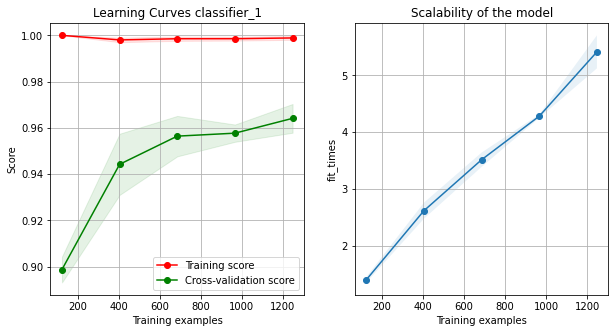

In [34]:
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_1', X_train, y_train)

In [ ]:
# Feature Engineering Model

In [60]:
classifier_2 = Pipeline([('fe', FeatureEngineering()),
                  ('classifier', XGBClassifier(scale_pos_weight=9)),
                 ])

In [61]:
param_grid_classifier_2 = {'classifier__max_depth': [5,10],
                'classifier__max_gamma': [0,0.5],
                'classifier__max_eta': [0.3,0.5]}

In [62]:
grid_classifier_2 = GridSearchCV(estimator=classifier_2, param_grid=param_grid_classifier_2, cv = 3)

In [63]:
grid_classifier_2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('fe',
                                        FeatureEngineering(avg_word_length=True,
                                                           char_count=True,
                                                           char_count_wo_space=True,
                                                           digit_count=True,
                                                           word_count=True)),
                                       ('classifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gam

In [64]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_2.best_score_))
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest Estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'classifier__max_depth': 5, 'classifier__max_eta': 0.3, 'classifier__max_gamma': 0}

Best Estimator:  Pipeline(memory=None,
         steps=[('fe',
                 FeatureEngineering(avg_word_length=True, char_count=True,
                                    char_count_wo_space=True, digit_count=True,
                                    word_count=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5, max_eta=0.3,
                               max_gamma=0, min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha

In [65]:
file_model_feature_engineering = save_model_folder / 'feature_engineering_model.pkl'
joblib.dump(grid_classifier_2.best_estimator_, file_model_feature_engineering)

['/content/drive/MyDrive/NLP/saved_models/feature_engineering_model.pkl']

In [66]:
grid_classifier_2_train_score = grid_classifier_2.score(X_train, y_train)
print(f'Accuracy on train set is {grid_classifier_2_train_score}')

Accuracy on train set is 0.9980769230769231


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

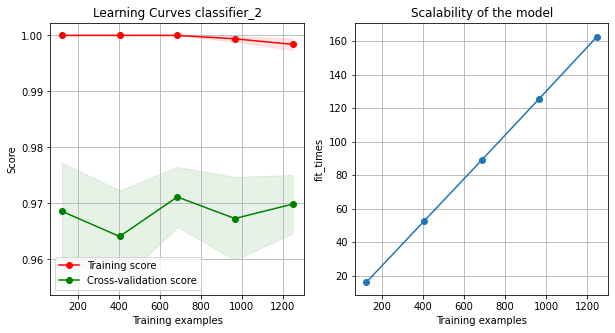

In [67]:
loaded_model_sparse_embed = joblib.load(file_model_feature_engineering)
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_2', X_train, y_train)

In [68]:
# Featurization (TF-IDF) + Feature Engineering + ML Model pipeline

In [69]:
vectorization = Pipeline([ ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ])                        
feature_engineering = FeatureEngineering()
combined_features = FeatureUnion([("vec", vectorization), ("fe", feature_engineering)])

In [70]:
classifier_3 = Pipeline([('cf', combined_features),
                  ('classifier', XGBClassifier(scale_pos_weight=9)),
                 ])

In [71]:
param_grid_classifier_3 = {'cf__vec__vectorizer__max_features': [500, 1000, 2000, None],
                           'cf__vec__vectorizer__max_df': [0.8, 0.6],
                           'classifier__max_depth': [5,10],
                           'classifier__max_gamma': [0,0.5],
                           'classifier__max_eta': [0.3,0.5]}

In [72]:
grid_classifier_3 = GridSearchCV(estimator=classifier_3, param_grid=param_grid_classifier_3, cv = 2 )

In [73]:
grid_classifier_3.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cf',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('vec',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('vectorizer',
                                                                                         TfidfVectorizer(analyzer='word',
                                                                                                         binary=False,
                                                                                                         decode_error='strict',
                                                                                                         dtype=<class 'numpy.float64'>,
                          

In [74]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("Best parameters: ", grid_classifier_3.best_params_)

Best cross-validation score: 0.98
Best parameters:  {'cf__vec__vectorizer__max_df': 0.8, 'cf__vec__vectorizer__max_features': 2000, 'classifier__max_depth': 10, 'classifier__max_eta': 0.3, 'classifier__max_gamma': 0}


In [75]:
file_model_feature_sparse = save_model_folder / 'feature_sparse_model.pkl'
joblib.dump(grid_classifier_3.best_estimator_, file_model_feature_sparse)

['/content/drive/MyDrive/NLP/saved_models/feature_sparse_model.pkl']

In [76]:
grid_classifier_3_train_score = grid_classifier_3.score(X_train, y_train)
print(f'Accuracy on train set is {grid_classifier_3_train_score}')

Accuracy on train set is 1.0


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

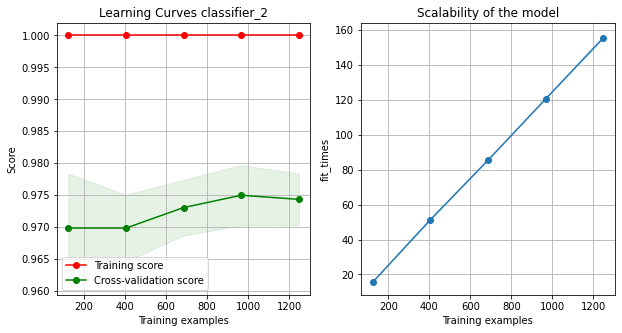

In [77]:
file_model_feature_sparse = save_model_folder / 'feature_sparse_model.pkl'
loaded_model_sparse_embed = joblib.load(file_model_feature_sparse)
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_2', X_train, y_train)

In [ ]:
Evaluate model on test datset

In [1]:
# Making final predictions
def final_pipeline(model, text):
  cleaned_text = SpacyPreprocessor(remove_stop=False).transform(text)
  predictions = model.predict(cleaned_text)
  return predictions


In [35]:
# predicted values for Test data set for Classifier 1
file_model_sparse_embed = save_model_folder / 'sparse_embed_model.pkl'
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

y_test_pred = final_pipeline(loaded_model_sparse_embed, np.array(X_test))
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

         ham       0.98      0.97      0.97       580
        spam       0.82      0.84      0.83        89

    accuracy                           0.95       669
   macro avg       0.90      0.91      0.90       669
weighted avg       0.95      0.95      0.95       669



In [36]:
# predicted values for Test data set for Classifier 2
file_model_feature_engineering = save_model_folder / 'feature_engineering_model.pkl'
loaded_model_feature_engineering = joblib.load(file_model_feature_engineering)

y_test_pred = final_pipeline(loaded_model_feature_engineering, np.array(X_test))
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

         ham       0.98      0.99      0.98       580
        spam       0.93      0.87      0.90        89

    accuracy                           0.97       669
   macro avg       0.95      0.93      0.94       669
weighted avg       0.97      0.97      0.97       669



In [37]:
# predicted values for Test data set for Classifier 3
file_model_feature_sparse = save_model_folder / 'feature_sparse_model.pkl'
loaded_model_feature_sparse = joblib.load(file_model_feature_sparse)

y_test_pred = final_pipeline(loaded_model_feature_sparse, np.array(X_test))
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       580
        spam       0.94      0.90      0.92        89

    accuracy                           0.98       669
   macro avg       0.96      0.95      0.95       669
weighted avg       0.98      0.98      0.98       669

